导入库
=====================
bs4.BeautifulSoup 用于解析html网页源码  
  
urllib.request.urlopen 用于打开url和读取url链接里面的信息  
  
urllib.error.* 用于捕捉各种网络连接时产生的异常状态  
  
re 用于正则匹配  
  
pandas 用于处理和存储数据  
  
json 用于处理json或类json的数据

In [1]:
from bs4 import BeautifulSoup 
from urllib.request import urlopen
from urllib.error import *
import re 
import pandas as pd
import json


# 爬取流程简介

######  因为链家二手房每页只展示30个房源信息，且最多显示100页，当一个区域多于30*100套房源时，例如像单独搜索浦东新区时，我们就无法爬取所有的房源信息  
######  所以我们要具体到每个行政区域下的每个板块去爬取房源信息
###### 具体的流程为   
###### 1、爬取每个行政区域的链接
###### 2、在爬取到的行政区域链接的页面中，爬取每个行政区域下对应的板块区域链接
###### 3、在爬取到每个板块区域链接中，爬取当前页面中所有房源的编号，然后根据编号进入到对应的页面爬取具体的信息。
###### 4、当前区域的所有房源信息爬取完毕后，进入下一个区域爬取对应的房源信息。


# 链接分析

### 链家上海二手房房源展示链接：https://sh.lianjia.com/ershoufang/biyun/pg2/  
 
###### https://sh.lianjia.com/
为基本的链接  
###### /ershoufang  
为房屋售卖的信息，这里为二手房的意思
###### /biyun  
为板块信息，这里为(浦东)碧云板块  
###### /pg2   
为页面信息，这里为第一页  

### 链家上海房源具体信息示例链接：https://sh.lianjia.com/ershoufang/107001505831.html
 
###### https://sh.lianjia.com/
为基本的链接  
###### /ershoufang  
为房屋售卖的信息，这里为二手房的意思
###### /biyun  
为板块信息，这里为(浦东)碧云板块  
###### /107001505831.html
其中的数字为房源链家编号  


# 步骤1、
#### 首先打开网页https://sh.lianjia.com/ershoufang/ ,如图  

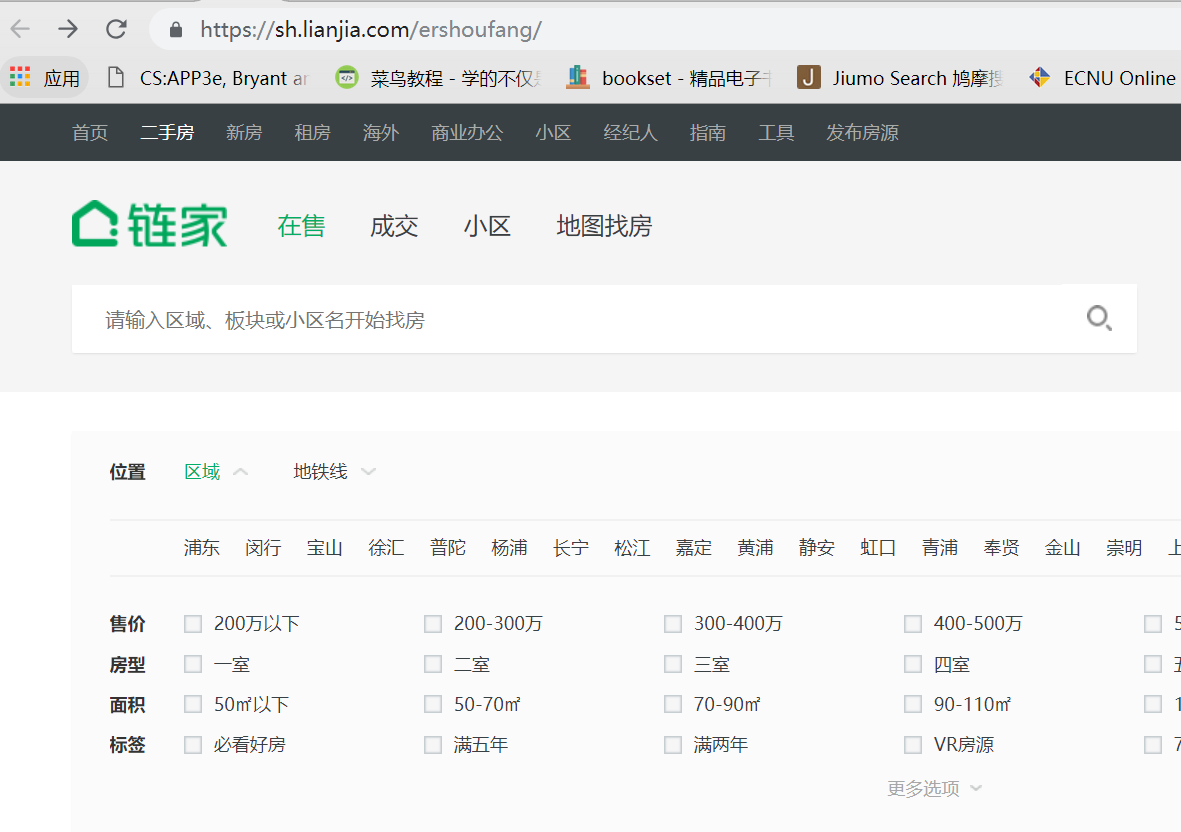

#### 鼠标右击"浦东"按钮，选择检查

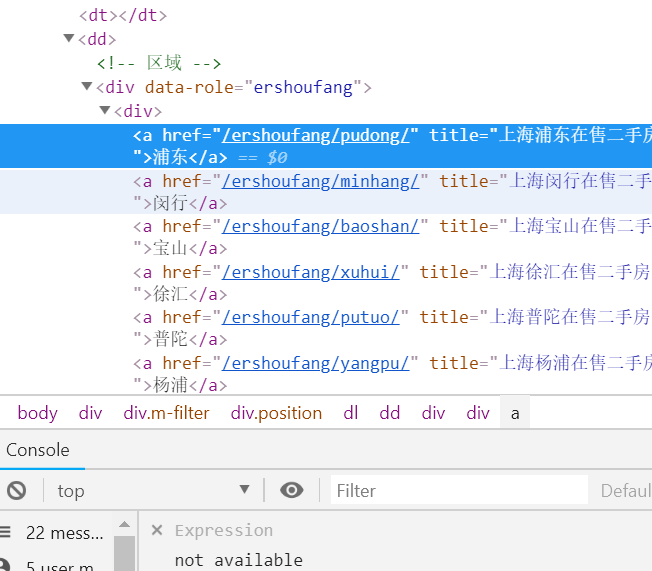

#### 需要提取对应标签中的href属性（最后一个除外）
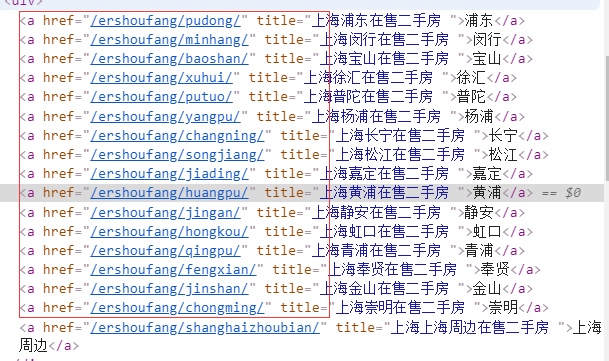

In [2]:
BaseUrl = "https://sh.lianjia.com"
SecondLink = "/ershoufang"
Url = BaseUrl + SecondLink

Html = urlopen(Url).read().decode("utf-8")
Soup = BeautifulSoup(Html, features="html.parser")

#用herf属性和title属性去匹配相对应的标签
#前一个正则表达式匹配href属性中以"/ershoufang/"开头的数据
#后一个正则表达式表示title属性中以"上海XX在售二手房"开头的数据

FilitedLabel = Soup.find_all("a", {"href":re.compile("^/ershoufang/"), "title": re.compile("^上海.{2}在售二手房")}) 

# 将标签中的href属性中的数据提取出来构建一个列表
DistrictLink = [filitedLabel['href'] for filitedLabel in FilitedLabel]

# 步骤2、

####  提取如图对应的一系列标签
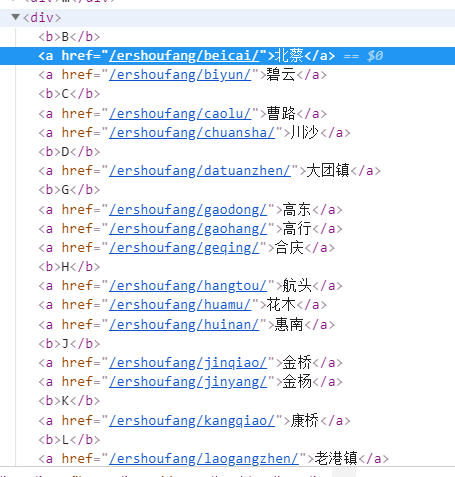


In [ ]:

BlockLink = []
#将每个区中的板块提取出来
for districtLink in DistrictLink:
    # 以字符'/'作为分隔符拆分字符串，并提取其中的第三个字符串
    district = districtLink.split('/')[2]
    
    Url = BaseUrl + districtLink
    
    Html = urlopen(Url).read().decode("utf-8")
    Soup = BeautifulSoup(Html, features="html.parser")
    
    # 提取该标签比较复杂
    # 正则表达式表达的是匹配href属性中以/ershoufang开头/且后不接当前的行政区名字符串，'/'在最后且之前和在/ershoufang/之后没有任何'/'字符串的字符串
    # "title":None 表示没有title属性
    FilitedLabel = Soup.find_all("a", {"href":re.compile("^/ershoufang/((?!" +  district + "/)[^/]*?/)"), "title":None})
    
    BlockLink.extend([filitedLabel['href'] for filitedLabel in FilitedLabel])

# 查看所有的板块链接 
BlockLink

# 步骤3、4

#### 提取每个板块对应的最大页面数，很明显属性page-data里存储的数据是一个json字符串数据，可以用json对其进行处理转为字典再提取其中的数据
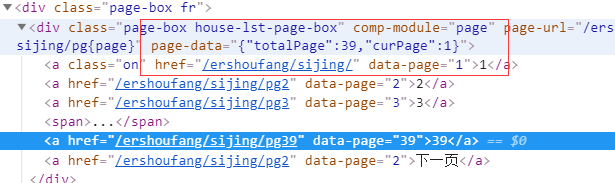

#### 然后在每个页面提取房源编号，对其进行访问提取信息。  
#### 提取房源编号的方法有很多，如下图所示
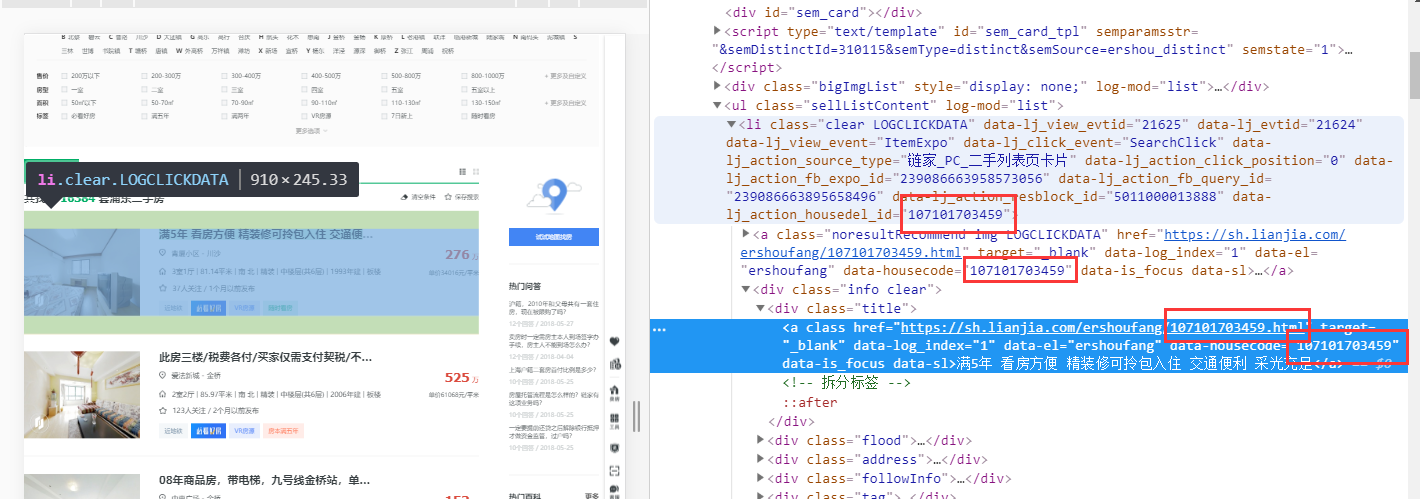  
#### 我选择的是"data-lj_action_housedel_id"属性，因为每个房源对应的html代码中有且仅有一个该属性

#### 爬取完该页面所有的房源编码后，我们就根据得到的房源编码跳转对应的页面

#### 我们要提取的数据如下列图所示：
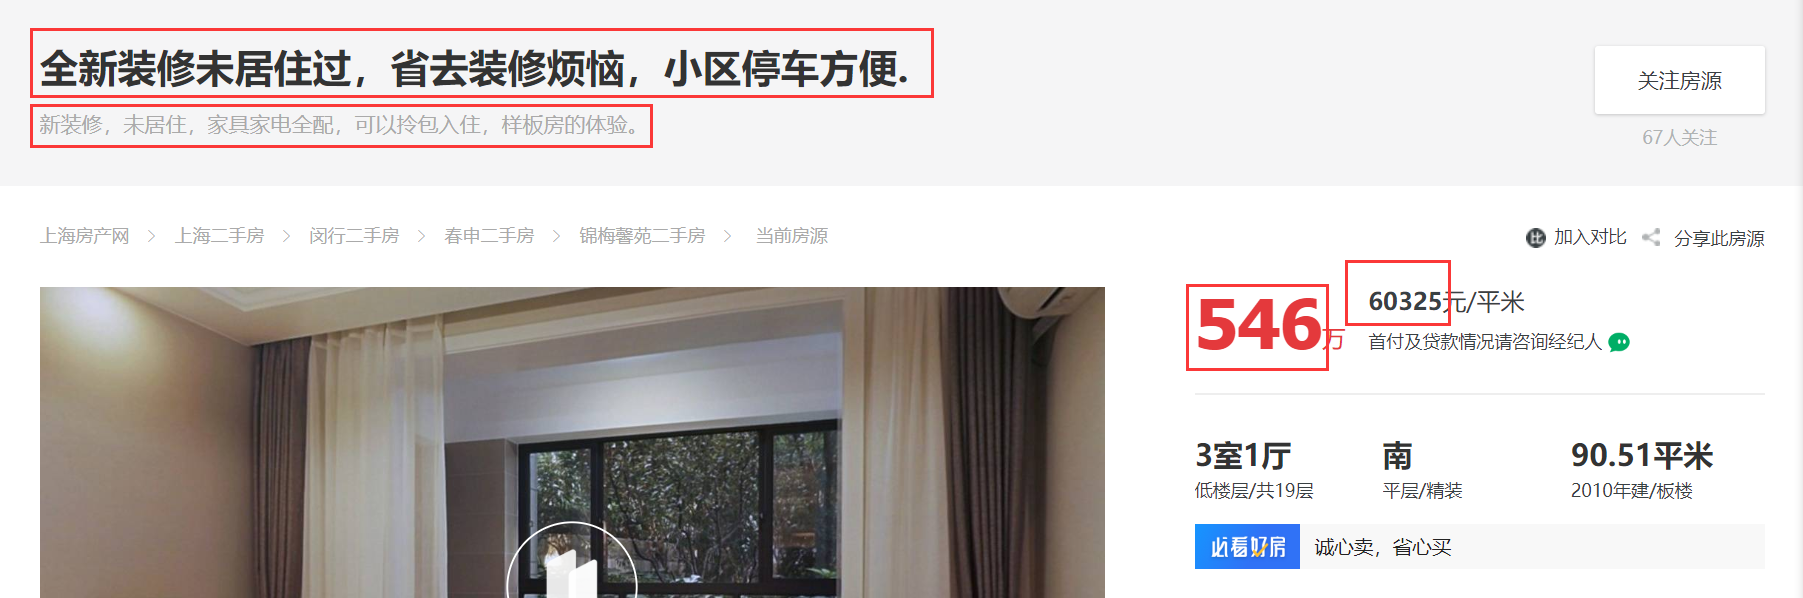
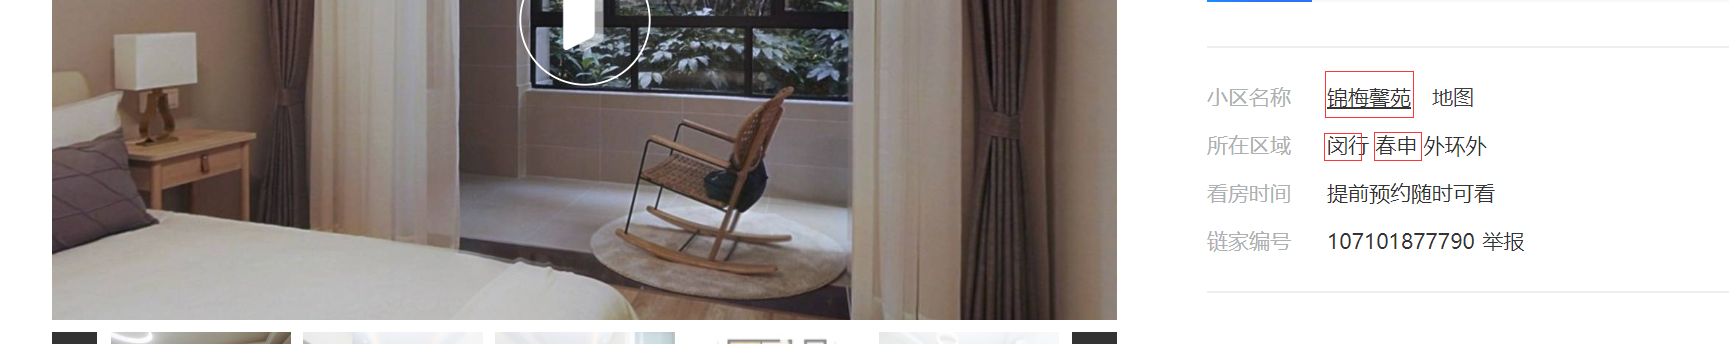
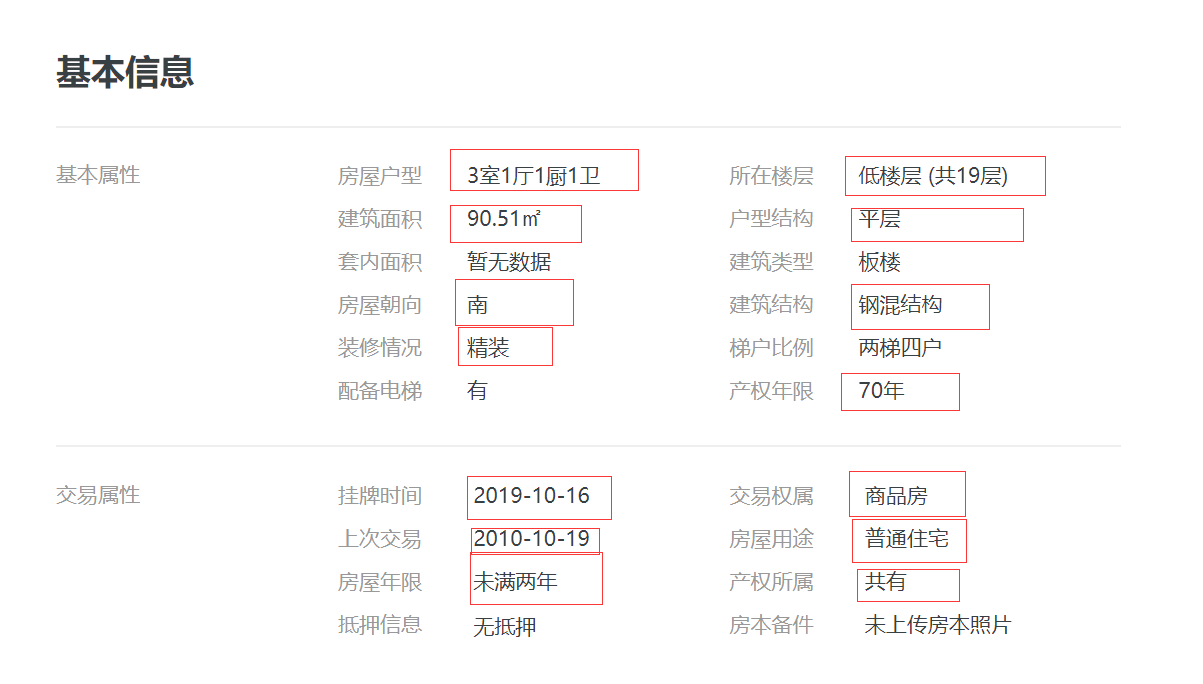
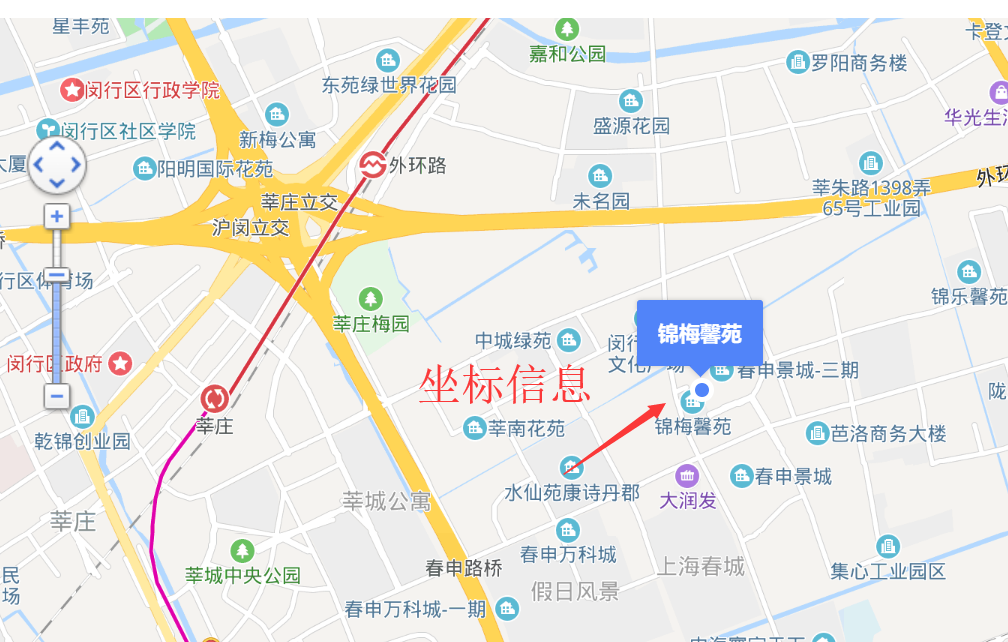

##  因为提取数据的方法有很多技巧，这里主要简略介绍我的提取方法

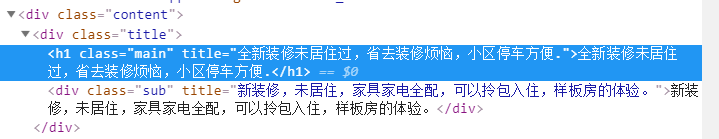
#### 我们可以直接提取对应的主标题和副标题（注：这两个标题都在title属性中）

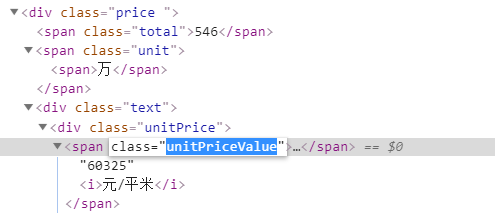
#### 总价和单价也可以直接提取（我直接提取了数字，扔掉了后面的单位）

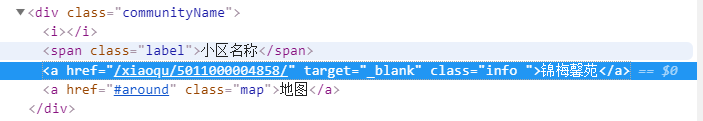
#### 我这里根据上一级标签div class="communityName"提取整个div内容的信息，然后再提取其中第二个数据的文本

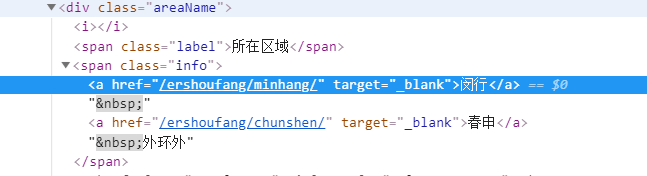
#### 因为属性class="info" 涉及到的标签很多不好筛选，我这里根据上级标签div class="areaName"和 当前标签div class="info"筛选，然后再提取其中的第一个文本数据，第二个文本数据

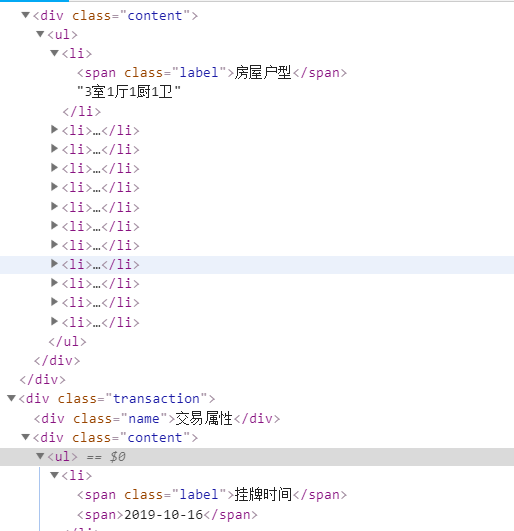
#### 接下来一大堆数据都存储在div class="content"下的ul标签下，这里标签重复太多数据不好爬取，只能依次遍历爬取。先根据文本数据中前四个字用if语句判断其是什么数据，然后再提取后面的文本数据。

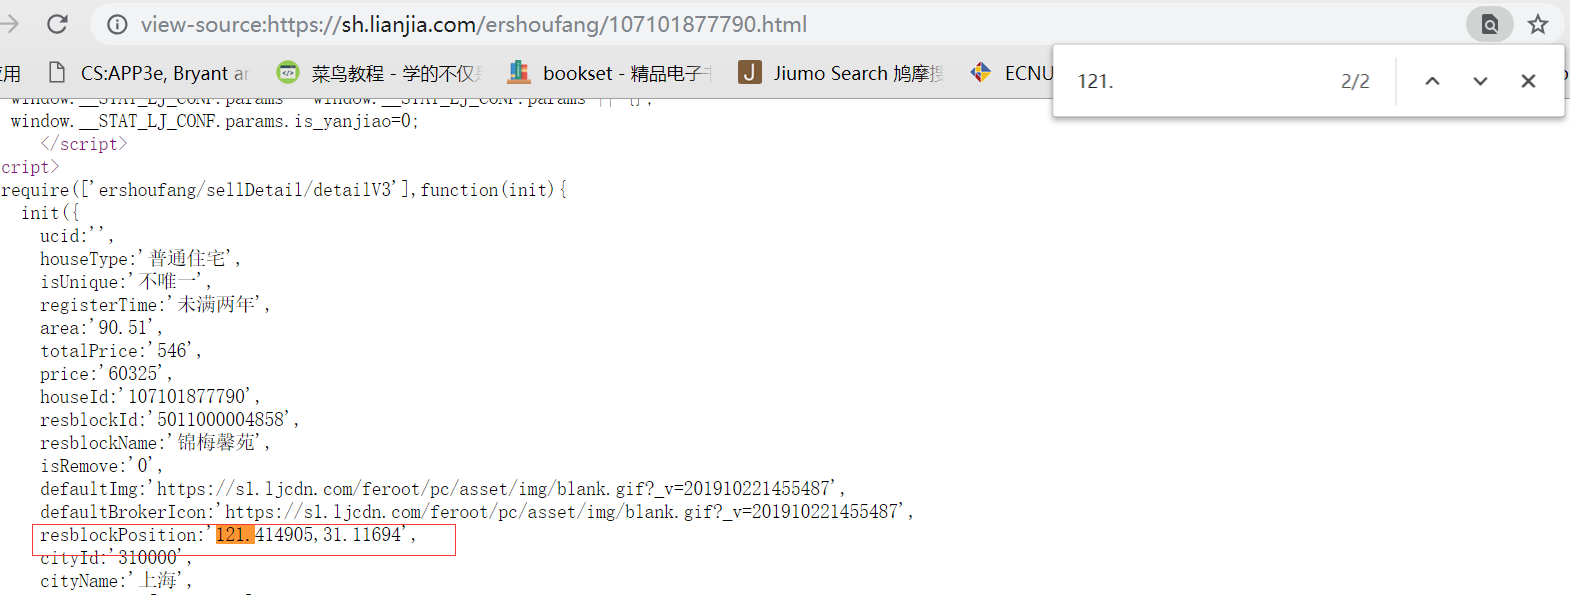
#### 坐标数据并没有在页面中显示出来，因为调用了地图，所以页面中应该会存在坐标数据。我们直接查看源码，搜索"121."查询得到的第二个数据就是坐标数据了（第一个是上海市中心的数据，而且上海基本住人的地区坐标经度整数部分都为121），因为BeautifulSoup会处理掉该部分数据，所以我直接用BeautifulSoup处理之前的源码数据用正则表达式进行提取。

In [5]:
# 注：打印网页链接主要是可以用来查看爬取的进度


# 设置一个新字典，存储爬取到每个房源的信息
HouseInfomation = {}

for blockLink in BlockLink:
    BlockUrl = BaseUrl + blockLink
    
    #这里捕捉URLError和TimeoutError，其实都是访问Html页面出错，所以重新访问该页面，如果没有出错就跳出该循环
    while True:
        try:
            Html = urlopen(BlockUrl).read().decode("utf-8")
            break
        except (URLError,TimeoutError):
            continue
    
    Soup = BeautifulSoup(Html, features="html.parser")
    
    #获取每个地区二手房页数
    try:
        #这里的获取到的数据明显是json形式的，所以将其用json解析为字典再获取其中键为totalPage的数据
        PageNum = json.loads(Soup.find("div", {"page-data": re.compile("")})['page-data'])['totalPage']
    except TypeError:
        # 这种异常发生在页面没有房源或只有一页的情况下
        PageNum = 1
        
    for i in range(1, PageNume + 1, 1):
        
        BlockPageUrl = BlockUrl + "pg{}".format(i)
        
        while True:
            try:
                Html = urlopen(BlockPageUrl).read().decode("utf-8")
                break
            except (URLError,TimeoutError):
                continue
        Soup = BeautifulSoup(Html, features="html.parser")
        
        # 将存有其中的所有的房源编码的所有标签提取出来
        FilitedLabel = Soup.find_all("li", {"data-lj_action_housedel_id": re.compile("[0-9]*?")})
        
        # 再将标签中的房源编码提取出来
        HouseId = [filitedLabel['data-lj_action_housedel_id'] for filitedLabel in FilitedLabel]
        
        
        for houseId in HouseId:
        
            # 组合构成房源页面的链接
            HouseUrl = BaseUrl + SecondLink + "/{}.html".format(houseId)
            
            while True: 
                try:
                    Html = urlopen(HouseUrl).read().decode("utf-8")
                    break
                except (URLError,TimeoutError):
                    continue
            Soup = BeautifulSoup(Html, features='html.parser')

            # 提取主表题和副标题
            Title = Soup.find_all("div", class_='title')[0]
            MainTitle = Soup.find("h1")['title'].replace('\n', '')
            SubTitle = Soup.find("div", class_="sub")['title'].replace('\n', '')
            
            # 提取坐标
            Coordination = re.findall("resblockPosition:\'([0-9\.,]*?)\'", Html)
            
            # 提取总价和单价
            TotalPrice = Soup.find("span", class_='total').get_text()
            UnitPrice =Soup.find("span", class_='unitPriceValue').contents[0]
            
            # 提取小区名字
            CommunityName = Soup.find("div", class_="communityName").contents[2].get_text()
            
            # 提取行政区信息和板块信息
            LocationInformation = Soup.select("div.areaName span.info a")
            DistrictWhereHouseIsLocated = LocationInformation[0].get_text()
            BlockWhreHouseIsLocated = LocationInformation[1].get_text()
            
            # 预先定义好一系列的信息
            HouseStyle = ""
            HouseFloor = ""
            HouseArea = ""
            HouseType = ""
            HouseStructure = "" 
            HouseType = ""
            HouseOrientation = ""
            HouseDecoration = ""
            HouseListingTime = ""
            HouseLastSaleTime = ""
            HouseYearOfProperty = ""
            HouseTranscationType = ""
            HousePropertyRight = ""
            
            # 然后爬取一系列的数据
            BasicInfomation = Soup.select("div.content ul li")
            for basicInfomation in BasicInfomation:
                Label = basicInfomation.get_text().replace('\n', '')[:4]
                if Label == "房屋户型":
                    HouseStyle = basicInfomation.contents[1]
                elif Label == "所在楼层":
                    HouseFloor = basicInfomation.contents[1]
                elif Label == "建筑面积":
                    HouseArea = basicInfomation.contents[1]
                elif Label == "建筑类型" or Label == "别墅类型":
                    HouseType = basicInfomation.contents[1]
                elif Label == "房屋朝向":
                    HouseOrientation = basicInfomation.contents[1]
                elif Label == "建筑结构":
                    HouseStructure = basicInfomation.contents[1]
                elif Label == "装修情况":
                    HouseDecoration = basicInfomation.contents[1]
                elif Label == "产权年限":
                    HouseYearOfProperty = basicInfomation.contents[1]
                elif Label == "挂牌时间":
                    HouseListingTime = basicInfomation.contents[3].get_text()
                elif Label == "上次交易":
                    HouseLastSaleTime = basicInfomation.contents[3].get_text()
                elif Label == "交易权属":
                    HouseTranscationType = basicInfomation.contents[3].get_text()
                elif Label == "房屋用途":
                    HouseUsage = basicInfomation.contents[3].get_text()
                elif Label == "产权所属":
                    HousePropertyRight = basicInfomation.contents[3].get_text()

            HouseInfomation[houseId] = [MainTitle, SubTitle, TotalPrice, UnitPrice, Coordination, CommunityName, 
                                        DistrictWhereHouseIsLocated, BlockWhreHouseIsLocated,
                                       HouseStyle, HouseFloor, HouseArea, HouseType, HouseStructure, HouseOrientation,
                                       HouseDecoration, HouseYearOfProperty,HouseListingTime, HouseLastSaleTime,
                                        HouseTranscationType, HouseUsage, HousePropertyRight]

https://sh.lianjia.com/ershoufang/beicai/
https://sh.lianjia.com/ershoufang/107101834549.html
https://sh.lianjia.com/ershoufang/107101704105.html
https://sh.lianjia.com/ershoufang/107101434208.html
https://sh.lianjia.com/ershoufang/107101800211.html
https://sh.lianjia.com/ershoufang/107101626870.html
https://sh.lianjia.com/ershoufang/107101592609.html
https://sh.lianjia.com/ershoufang/107101741236.html
https://sh.lianjia.com/ershoufang/107101841491.html
https://sh.lianjia.com/ershoufang/107101631897.html
https://sh.lianjia.com/ershoufang/107100434909.html
https://sh.lianjia.com/ershoufang/107101842283.html
https://sh.lianjia.com/ershoufang/107101517628.html
https://sh.lianjia.com/ershoufang/107101819466.html
https://sh.lianjia.com/ershoufang/107101461172.html
https://sh.lianjia.com/ershoufang/107101712861.html
https://sh.lianjia.com/ershoufang/107101105799.html
https://sh.lianjia.com/ershoufang/107101785394.html
https://sh.lianjia.com/ershoufang/107101690242.html
https://sh.lianjia.com

In [6]:
#根据字典的内容生生成一个DataFrame存储数据
House = pd.DataFrame(HouseInfomation, index=['主标题', '副标题', '总价（万元）', '单价（元）', '坐标', '小区', '所在区域', '所在板块',
                                            '房屋户型', '所在楼层', '建筑面积', '建筑类型', '建筑结构', '房屋朝向','装修情况',
                                            '产权年限', '挂牌时间', '上次交易', '交易权属', '房屋用途', '产权所属']).T

In [7]:
#查看House
House

,主标题,副标题,总价（万元）,单价（元）,坐标,小区,所在区域,所在板块,房屋户型,所在楼层,...,建筑类型,建筑结构,房屋朝向,装修情况,产权年限,挂牌时间,上次交易,交易权属,房屋用途,产权所属
107101834549,刚需小户型 小区央座 双轨交通 业主急售 产权清晰,此房满三年 税费少 楼间距宽采光充足 内部配套设施齐全,340,47680,"[121.565444,31.19014733]",莲溪一村,浦东,北蔡,2室1厅1厨1卫,中楼层 (共7层),...,板楼,钢混结构,南,简装,70年,2019-10-09,暂无数据,商品房,普通住宅,共有
107101704105,急售，空间很大，看房基本随时方便，地铁500米。,此房一手动迁，税费少，离地铁13号线华鹏路站步行500米进站。。,520,69278,"[121.533269,31.187226]",大华锦绣华城(二街区),浦东,北蔡,2室2厅1厨1卫,低楼层 (共6层),...,板楼,钢混结构,南,毛坯,未知,2019-08-31,暂无数据,商品房,普通住宅,共有
107101434208,中区2房 双南南北通透 采光好 7号线出行方便,年底满2年 南北通透双南格局 中间楼层 采光充足 交通便利,750,89918,"[121.540618,31.201125]",陆家嘴锦绣前城,浦东,北蔡,2室2厅1厨1卫,低楼层 (共22层),...,板楼,钢混结构,南 北,精装,70年,2019-06-16,2017-11-03,商品房,普通住宅,非共有
107101800211,7/13号线地铁 电梯高层 南北通 （无增值税无个税）,业主售房诚意度高，南北通，得房率高，本小区必看好房（一定看,615,69808,"[121.53906,31.189746]",大华锦绣华城(九街区),浦东,北蔡,2室1厅1厨1卫,高楼层 (共14层),...,板楼,钢混结构,南,简装,未知,2019-09-28,暂无数据,商品房,普通住宅,共有
107101626870,2000年商品房，满五年唯一，诚意出售，价格可谈,急售，绿川新苑北区，纯商品房小区，满五年唯一，价格可谈,367,46321,"[121.554494,31.179046]",绿川新苑,浦东,北蔡,2室1厅1厨1卫,高楼层 (共6层),...,板楼,砖混结构,南,简装,未知,2019-08-10,2001-07-21,商品房,普通住宅,非共有
107101592609,大华锦绣华城(一街区) 1室2厅 380万,链家网真房源，更多房源信息请联系经纪人,380,67126,"[121.5328262,31.19034135]",大华锦绣华城(一街区),浦东,北蔡,1室2厅1厨1卫,高楼层 (共18层),...,板楼,钢混结构,南,精装,70年,2019-07-31,2010-06-30,商品房,普通住宅,共有
107101741236,2003年竣工，一梯两户，20万精装修，停车方便,2003年竣工，一梯两户，川杨河跑道，停车方便。,356,48841,"[121.554494,31.179046]",绿川新苑,浦东,北蔡,2室1厅1厨1卫,中楼层 (共6层),...,板楼,砖混结构,南,精装,未知,2019-09-11,2017-10-28,商品房,普通住宅,非共有
107101841491,满五年 板式户型 南北两房 +5平米小书房 有地暖,开发商统一装修全配 拎包入住 大金空调 人车分流,745,83906,"[121.532112,31.181295]",大华锦绣华城(十四街区),浦东,北蔡,2室2厅1厨1卫,高楼层 (共18层),...,板楼,钢混结构,南,精装,70年,2019-10-11,2012-08-27,商品房,普通住宅,共有
107101631897,绿地集团建造、总高6楼的5楼、房子满五唯一、省税！,此房满五唯一的，总高六楼的五楼，房东自住，看房方便！,221.9,44997,"[121.5571847,31.17677686]",绿川小区,浦东,北蔡,1室1厅1厨1卫,高楼层 (共6层),...,板楼,砖混结构,南,精装,未知,2019-08-11,2009-09-03,商品房,普通住宅,共有
107100434909,稀有浅色系4房 视野开阔 我有钥匙 业主急售,房东诚意卖，景观楼层，位置好，一户一梯，看房很方便,2300,94725,"[121.542044,31.198949]",浦东星河湾,浦东,北蔡,4室3厅1厨4卫,低楼层 (共18层),...,板楼,钢混结构,南,精装,70年,2018-07-04,2010-01-17,商品房,普通住宅,非共有


In [8]:
# 然后导出数据,存储为csv格式，编码为UTF-8，否则会乱码
House.to_csv("House.csv", encoding='utf-8-sig')